Aim of the project:
- To recommend content to the users based on their interactions with the OTT platform.
- This helps them get into a habit of regularly visiting the platform and engaging with the content, which in turn helps the platform to increase the user engagement, and hence the user base.
- This finally helps with user retention and user satisfaction.
- If recommendations are not possible, we need to recommend the Top 10 movies with the most ratings.

### Package installation and import

In [157]:
# %pip install numpy pandas scikit-learn

In [158]:
import os

# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# np.random.seed(42)

### Data collection

In [159]:
datasets_dir = 'datasets'
dataset_foldername = 'ml-latest-small'

zip_file = os.path.join(datasets_dir, dataset_foldername + '.zip')
extracted_folder = zip_file.replace('.zip', '')
ratings_file = os.path.join(extracted_folder, 'ratings.csv')
movies_file = os.path.join(extracted_folder, 'movies.csv')
user_tags_file = os.path.join(extracted_folder, 'tags.csv')


# Create 'datasets' directory if it doesn't exist
if not os.path.exists(datasets_dir):
	os.makedirs(datasets_dir)


# if the dataset files don't exist
if any(not os.path.exists(file) for file in [ratings_file, movies_file, user_tags_file]):
	# ensure zipfile exists
	if not os.path.exists(zip_file):
		print(f'Downloading {dataset_foldername}.zip...')
		os.system(f'wget -P {datasets_dir} https://files.grouplens.org/datasets/movielens/{dataset_foldername}.zip > /dev/null 2>&1')
	
	# delete existing ml-latest-small folder
	if os.path.exists(extracted_folder):
		os.rmdir(extracted_folder)
	print(f'Extracting {zip_file}...')
	os.system(f'unzip -d {datasets_dir} {zip_file} > /dev/null 2>&1')
	os.remove(zip_file)

ratings = pd.read_csv(ratings_file)
movies = pd.read_csv(movies_file)
user_tags = pd.read_csv(user_tags_file)

ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [160]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [161]:
user_tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


### Data Transformation

In [162]:
# Data Cleaning
# Drop any rows with missing values from the ratings, movies and user_tags dataframes
ratings.dropna(inplace=True)
movies.dropna(inplace=True)
user_tags.dropna(inplace=True)

user_tags.rename(columns={'tag': 'user_tag'}, inplace=True)

# Data Manipulation and Wrangling
# drop timestamp
ratings.drop(columns=['timestamp'], inplace=True)
user_tags.drop(columns=['timestamp'], inplace=True)

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Data Preprocessing

In [163]:
# in movies, if genre is "(no genres listed)", replace with NA
movies['genres'] = movies['genres'].apply(lambda x: x if x != "(no genres listed)" else None)

# Split genres into a list in movies dataframe
if not isinstance(movies['genres'].iloc[0], list):
    movies['genres'] = movies['genres'].str.split('|')

# Merge the dataframes on 'movieId' to create a single dataframe
merged_df = pd.merge(ratings, movies, on='movieId')
merged_df.drop(columns=['title'], inplace=True)  # drop movie title
merged_df = pd.merge(merged_df, user_tags, on=['movieId', 'userId'], how='left')

if merged_df.isnull().sum().any():
    columns_with_missing_values = merged_df.columns[merged_df.isnull().any()].tolist()
    columns_with_missing_values = ', '.join(columns_with_missing_values)
    print(f"There are missing values in columns: {columns_with_missing_values}")

merged_df.head()

There are missing values in columns: genres, user_tag


,userId,movieId,rating,genres,user_tag
0,1,1,4.0,"[Adventure, Animation, Children, Comedy, Fantasy]",NaN
1,5,1,4.0,"[Adventure, Animation, Children, Comedy, Fantasy]",NaN
2,7,1,4.5,"[Adventure, Animation, Children, Comedy, Fantasy]",NaN
3,15,1,2.5,"[Adventure, Animation, Children, Comedy, Fantasy]",NaN
4,17,1,4.5,"[Adventure, Animation, Children, Comedy, Fantasy]",NaN


In [164]:
# display where merged_ratings_df is not NaN
merged_df[merged_df['user_tag'].notnull()].head()

,userId,movieId,rating,genres,user_tag
121,336,1,4.0,"[Adventure, Animation, Children, Comedy, Fantasy]",pixar
164,474,1,4.0,"[Adventure, Animation, Children, Comedy, Fantasy]",pixar
193,567,1,3.5,"[Adventure, Animation, Children, Comedy, Fantasy]",fun
241,289,3,2.5,"[Comedy, Romance]",moldy
242,289,3,2.5,"[Comedy, Romance]",old


### Data Exploration

#### EDA

In [165]:
print("Ratings Dataframe Info:")
print(ratings.info())
print("\nMovies Dataframe Info:")
print(movies.info())
print("\nUser Tags Dataframe Info:")
print(user_tags.info())

Ratings Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 3.1 MB
None

Movies Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9708 non-null   object
dtypes: int64(1), object(2)
memory usage: 304.4+ KB
None

User Tags Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3683 entries, 0 to 3682
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userId    3683 non-null   int6

#### Data Visualization

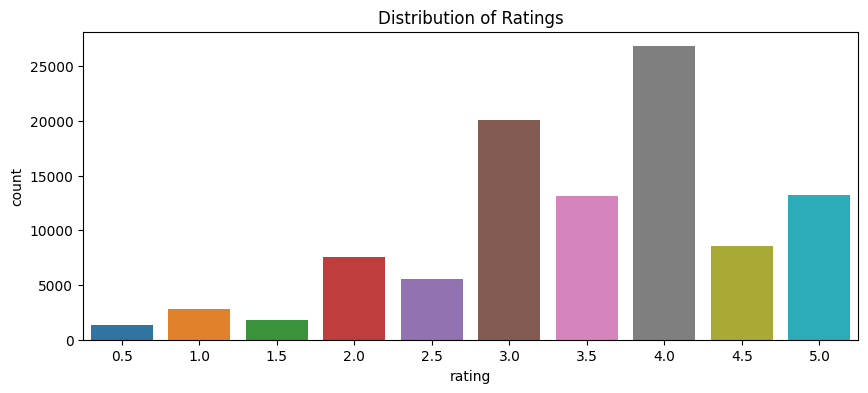

In [166]:
# Distribution of ratings
plt.figure(figsize=(10, 4))
sns.countplot(x="rating", data=ratings)
plt.title('Distribution of Ratings')
plt.show()

#### Top 10 movies with the most ratings

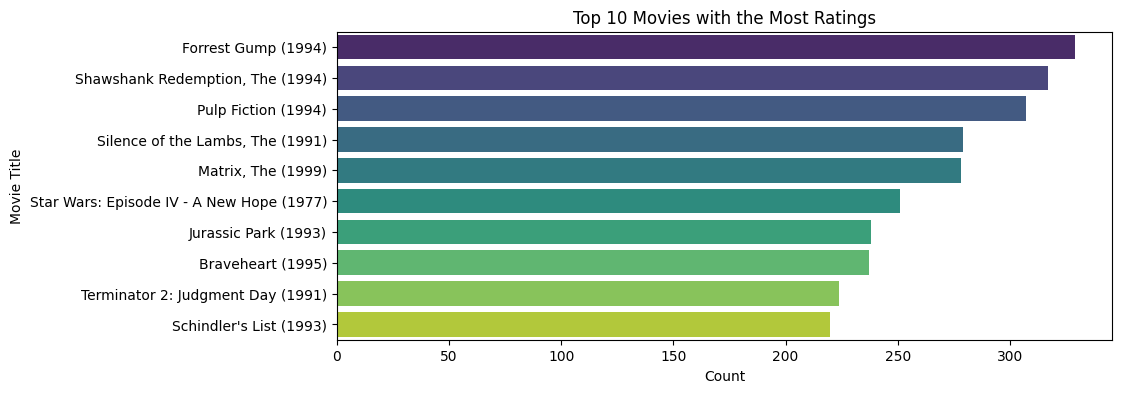

In [167]:
top_movies = ratings['movieId'].value_counts()[:10]
top_movies = pd.DataFrame({'movieId': top_movies.index, 'count': top_movies.values})
top_movies = pd.merge(top_movies, movies, on='movieId')

plt.figure(figsize=(10, 4))
sns.barplot(x='count', y='title', data=top_movies, palette='viridis')
plt.title('Top 10 Movies with the Most Ratings')
plt.xlabel('Count')
plt.ylabel('Movie Title')
plt.show()

### Feature Engineering

#### Feature Selection

In [169]:
unique_genres = merged_df['genres'].explode().unique().tolist()
unique_genres.remove(None)
merged_df_copy = merged_df.copy()

# Create a new column for each genre
for genre in unique_genres:
    merged_df_copy[genre] = merged_df_copy['genres'].apply(lambda x: int(genre in x) if x is not None else 0)

# Display the first few rows of the dataframe
merged_df_copy.head()

,userId,movieId,rating,genres,user_tag,Adventure,Animation,Children,Comedy,Fantasy,...,Mystery,Horror,Drama,War,Western,Sci-Fi,Musical,Film-Noir,IMAX,Documentary
0,1,1,4.0,"[Adventure, Animation, Children, Comedy, Fantasy]",NaN,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,5,1,4.0,"[Adventure, Animation, Children, Comedy, Fantasy]",NaN,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,7,1,4.5,"[Adventure, Animation, Children, Comedy, Fantasy]",NaN,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,15,1,2.5,"[Adventure, Animation, Children, Comedy, Fantasy]",NaN,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,17,1,4.5,"[Adventure, Animation, Children, Comedy, Fantasy]",NaN,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


#### Feature Extraction

#### Feature Scaling

#### Visualization of the selected features with pair plots

#### Correlation Matrix